## Assignment 3: $k$ Nearest Neighbor and $k$ Means Clustering

## **Do three questions.**

`! git clone https://www.github.com/DS3001/assignment3`

In [360]:
! git clone https://www.github.com/DS3001/assignment3

fatal: destination path 'assignment3' already exists and is not an empty directory.


In [361]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor as kNNRegression

**Q1.** This question is a case study for $k$ nearest neighbor. The target variable `y` is `Purchase` and the features of interest are `Age` and `AnnualSalary`.

1. Load the `./data/car_data.csv` data. Look at the head and dimensions of the data.
2. Summarize the variables (`User.ID`, `Gender`, `Age`, `AnnualSalary`, `Purchase`). Are there any missings to clean? Convert the `Gender` categorical variable into a dummy variable that takes the value 0 for male and 1 for female. Create a matrix $X$ of predictors including `Age` and `AnnualSalary`, and an outcome $y$ equaling `Purchase`.
3. MaxMin-normalize `Age` and `AnnualSalary` in `X`.
4. Split the sample into a ~80% training dataset and a ~20% testing dataset.
5. Treat this as a classification problem: The model is supposed to predict 0 or 1 for each customer, classifying them as a purchaser or non-purchaser. Use sklearn to determine the optimal number of neighbors $k$ to use.
6. Run the model for the optimal number of neighbors on the testing data. Cross tabulate the predicted outcomes against the actual outcomes; this is called a **confusion matrix**. How often does the model predict a sale when one fails to occur? How often does the model predict no sale when one does occur? Overall, does it provide accurate predictions?
7. Now, compute confusion matrices separately for men and women, as in part 6. Does the model make more accurate predictions for one sex or the other? Explain. (Performance of algorithms on population subgroups is a growing topic in data science.)

In [362]:
# Load data
car_dat = pd.read_csv("./assignment3/data/car_data.csv")
car_dat.head()

User ID Gender  Age  AnnualSalary  Purchased
0      385   Male   35         20000          0
1      681   Male   40         43500          0
2      353   Male   49         74000          0
3      895   Male   40        107500          1
4      661   Male   25         79000          0

In [363]:
# Summarize variables
car_dat.describe()

#pd.unique(car_dat['Gender'])

# Changed Gender to binary dummy
car_dat['Gender'] = car_dat['Gender'].replace('Male', 0).replace('Female', 1)
pd.unique(car_dat['Gender'])

# No other NaN values
print(car_dat.isnull().sum())


User ID         0
Gender          0
Age             0
AnnualSalary    0
Purchased       0
dtype: int64


In [364]:
# Create matrix X of predictors including Age and AnnualSalary, and outcome y equaling Purchase
y = car_dat['Purchased']
X = car_dat.loc[:, ['Age', 'AnnualSalary']]

# MaxMin-normalize Age and Salary in X
def maxmin(x):
  res = (x-min(x))/(max(x)-min(x))
  return res

X = X.apply(maxmin)
X.head()
X.describe()

Age  AnnualSalary
count  1000.000000   1000.000000
mean      0.491244      0.419556
std       0.237935      0.250824
min       0.000000      0.000000
25%       0.311111      0.228182
50%       0.488889      0.414545
75%       0.666667      0.545455
max       1.000000      1.000000

In [365]:
# Split into 80% training set and 20% testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=100)

In [366]:
# Regression function for Age and AnnualSalary
def plot_regression(X, y, k):

  model = kNNRegression(k)
  fitted_model = model.fit(X, y)

  N_x = 100
  N_y = 100 # Coarseness of y variable
  total = N_x*N_y # Total number of points to plot

  grid_x = np.linspace(0,1,N_x) # Create a grid of x values
  grid_y = np.linspace(0,1,N_y) # Create a grid of y values

  xs, ys = np.meshgrid(grid_x,grid_y) # Explode grids to all possible pairs
  X = xs.reshape(total) # Turns pairs into vectors
  Y = ys.reshape(total) # Turns pairs into vectors

  x_hat = pd.DataFrame({'Age':X,'AnnualSalary':Y}) # Create a dataframe of points to plot
  y_hat = fitted_model.predict(x_hat) # Fit the model to the points
  x_hat['Predicted'] = y_hat # Add new variable to the dataframe

  this_plot = sns.scatterplot(data=x_hat,x='Age',y='AnnualSalary',hue='Predicted') # Create seaborn plot
  sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1)) # Move legend off the plot canvas

  return x_hat


k where SSE is minimized: [9]


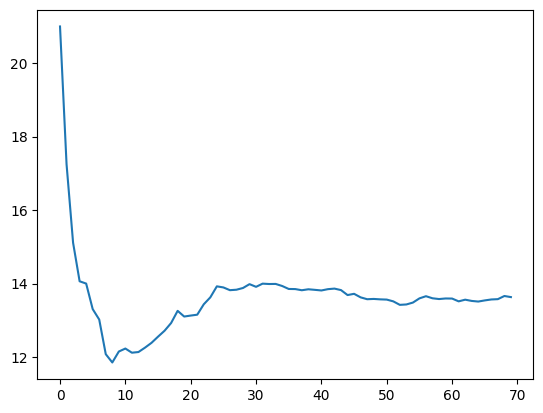

In [367]:
import matplotlib.pyplot as plt

# Determine optimal number of neighbors
k_bar = 70
k_grid = np.arange(1,k_bar)
SSE_train = np.zeros(k_bar)
SSE_test = np.zeros(k_bar)
for k in range(k_bar):
    model = kNNRegression(n_neighbors=k+1) # Create a sk model for k
    fitted_model = model.fit(X_train,y_train) # Train the model on our data
    y_hat = fitted_model.predict(X_test) # Predict values for test set
    SSE_test[k] = np.sum( (y_test-y_hat)**2 ) # Save the computed SSE
    y_hat = fitted_model.predict(X_train) # Predict values for training set
    SSE_train[k] = np.sum( (y_train-y_hat)**2 ) # Save the computed SSE

SSE_min = np.min(SSE_test) # Lowest recorded SSE
min_index = np.where(SSE_test == SSE_min) # Find the indices of y that equal the minimum
k_star = k_grid[min_index] # Find the optimal value of k

print("k where SSE is minimized:", k_star)

plt.plot(np.arange(0,k_bar),SSE_test,label='Test') # Plot SSE by k

Purchased    0    1
Predicted          
0.000000   305  181
0.111111     2    1
0.222222     4    2
0.333333     6    7
0.444444     3    6
0.555556     6    3
0.666667    22   15
0.777778    22   18
0.888889    88   61
1.000000   140  108

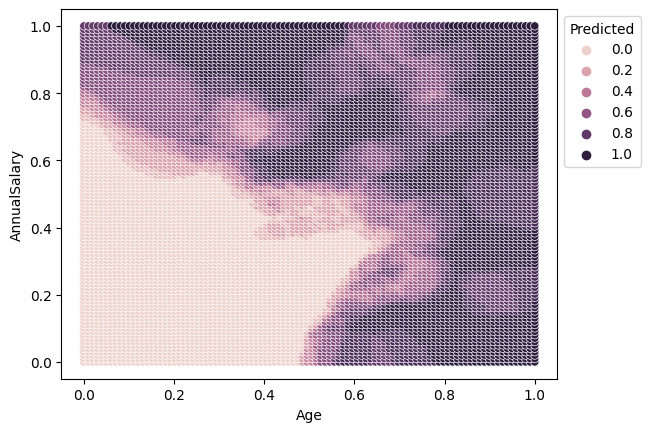

In [368]:
# Run the model for the optimal number of neighbors on the testing data. Cross tabulate
# the predicted outcomes against the actual outcomes; this is called a confusion matrix.
# How often does the model predict a sale when one fails to occur? How often does the model
# predict no sale when one does occur? Overall, does it provide accurate predictions?

x_hat = plot_regression(X_train, y_train, 9)

pd.crosstab(x_hat['Predicted'], car_dat['Purchased'])

# The model predicts sales more often when no sale is made. Of ~300 observations that had a predicted PURCHASE, a slight majority of them were observed to not be a Purchase.
# The model precicts non-purchasers better than purchasers. Of the ~500 observations that the model predicted NO PURCHASE, about 3/5 of them were observed to not be a Purchase.
# So, it incorrectly predicts no sale when one does occur about 2/5 of the time.
# Overall, a pretty poor predictor of Purchased variable.

count    10000.000000
mean         0.584100
std          0.439894
min          0.000000
25%          0.000000
50%          0.777778
75%          1.000000
max          1.000000
Name: Predicted, dtype: float64


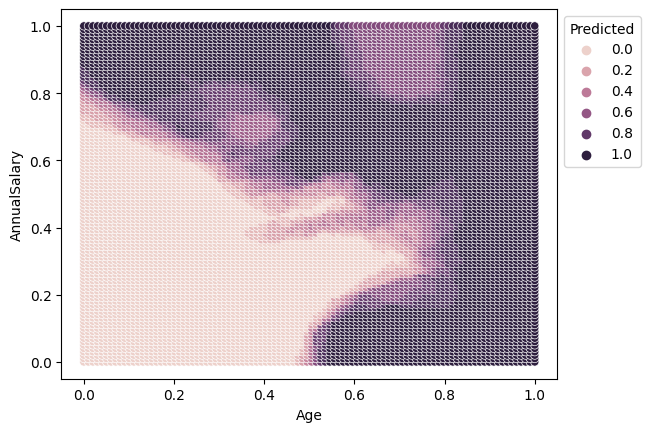

In [370]:
# Now, compute confusion matrices separately for men and women, as in part 6. Does the model make more accurate
# predictions for one sex or the other? Explain. (Performance of algorithms on population subgroups is a growing topic in data science.)

#male_obs = car_dat.loc[ car_dat['Gender']==0, ['Age', 'AnnualSalary', 'Purchased'] ] # all male rows
#female_obs = car_dat.loc[ car_dat['Gender']==1, ['Age', 'AnnualSalary', 'Purchased'] ] # all female rows

male_dat = car_dat.loc[car_dat['Gender'] == 0, ['Age', 'AnnualSalary', 'Purchased']]
#male_dat.head()

y = male_dat['Purchased']
X = male_dat[['Age', 'AnnualSalary']]

X = X.apply(maxmin)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=100)

# Run regression on all male observations
x_hat_male = plot_regression(X, y, k=9)

print(x_hat_male['Predicted'].describe())

#pd.crosstab(x_hat_male['Predicted'], y)



count    1.000000e+04
mean     1.111111e-01
std      5.551393e-17
min      1.111111e-01
25%      1.111111e-01
50%      1.111111e-01
75%      1.111111e-01
max      1.111111e-01
Name: Predicted, dtype: float64


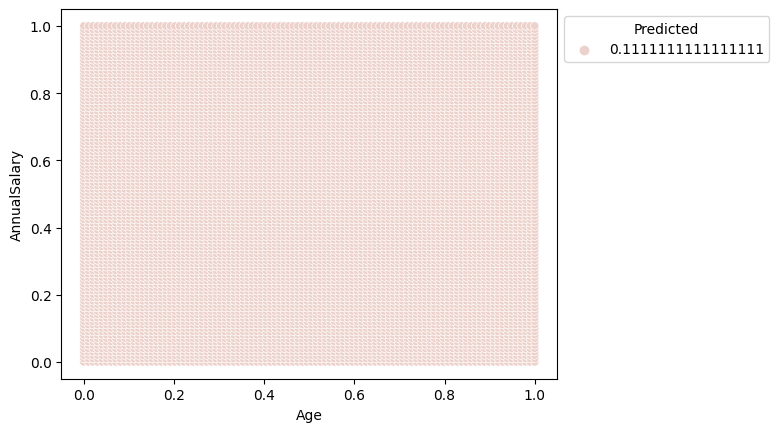

In [322]:

female_dat = car_dat.loc[car_dat['Gender'] == 1, ['Age', 'AnnualSalary', 'Purchased']]
#female_dat.head())


y = female_dat['Purchased']
X = female_dat[['Age', 'AnnualSalary']]

X.apply(maxmin)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=100)

# Run regression on all male observations
x_hat_female = plot_regression(X_train, y_train, k=9)

print(x_hat_female['Predicted'].describe())

**Q2.** This question is a case study for $k$ nearest neighbor The target variable `y` is `price` and the features are `year` and `mileage`.

1. Load the `./data/USA_cars_datasets.csv`. Keep the following variables and drop the rest: `price`, `year`, `mileage`. Are there any `NA`'s to handle? Look at the head and dimensions of the data.
2. Maxmin normalize `year` and `mileage`.
3. Split the sample into ~80% for training and ~20% for evaluation.
4. Use the $k$NN algorithm for regression and the training data to predict `price` using `year` and `mileage` for the test set for $k=3,10,25,50,100,300$. For each value of $k$, compute the Sum of Squared Error and make a scatterplot showing the test value plotted against the predicted value. What patterns do you notice as you increase $k$?
5. Determine the optimal $k$ for these data.
6. Describe what happened in the plots of predicted versus actual prices as $k$ varied, taking your answer into part 6 into account. (Hint: Use the words "underfitting" and "overfitting".)

In [323]:
# Load data
US_cars = pd.read_csv("./assignment3/data/USA_cars_datasets.csv")

# Keep price, year, mileage
US_cars = US_cars[['price', 'year', 'mileage']]
print(US_cars.isna().sum().any()) # returns False, no NaNs
print(US_cars.shape)
print(US_cars.head)

y = US_cars['price']
X = US_cars[['year', 'mileage']]


False
(2499, 3)
<bound method NDFrame.head of       price  year  mileage
0      6300  2008   274117
1      2899  2011   190552
2      5350  2018    39590
3     25000  2014    64146
4     27700  2018     6654
...     ...   ...      ...
2494   7800  2019    23609
2495   9200  2018    34553
2496   9200  2018    31594
2497   9200  2018    32557
2498   9200  2018    31371

[2499 rows x 3 columns]>


In [324]:
# Maxmin normalize year and mileage
# maxmin already defined
X = X.apply(maxmin)
X.describe()

year      mileage
count  2499.000000  2499.000000
mean      0.930091     0.051377
std       0.073248     0.058654
min       0.000000     0.000000
25%       0.914894     0.021088
50%       0.957447     0.034742
75%       0.978723     0.062354
max       1.000000     1.000000

In [325]:
# SPlit into 20% testing and 80% training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=100)


In [326]:
# Regression function using year and mileage
def plot_regression(X, y, k):

  model = kNNRegression(k)
  fitted_model = model.fit(X, y)

  N_x = 100
  N_y = 100 # Coarseness of y variable
  total = N_x*N_y # Total number of points to plot

  grid_x = np.linspace(0,1,N_x) # Create a grid of x values
  grid_y = np.linspace(0,1,N_y) # Create a grid of y values

  xs, ys = np.meshgrid(grid_x,grid_y) # Explode grids to all possible pairs
  X = xs.reshape(total) # Turns pairs into vectors
  Y = ys.reshape(total) # Turns pairs into vectors

  x_hat = pd.DataFrame({'year':X,'mileage':Y}) # Create a dataframe of points to plot
  y_hat = fitted_model.predict(x_hat) # Fit the model to the points
  x_hat['Predicted'] = y_hat # Add new variable to the dataframe

  this_plot = sns.scatterplot(data=x_hat,x='year',y='mileage',hue='Predicted') # Create seaborn plot
  sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1)) # Move legend off the plot canvas

  return x_hat


# Determine optimal number of neighbors
def compute_SSE(k, X_train, y_train, X_test, y_test):
  model = kNNRegression(k) # Create a sk model for k
  fitted_model = model.fit(X_train,y_train) # Train the model on our data
  y_hat = fitted_model.predict(X_test) # Predict values for test set
  SSE_test = np.sum( (y_test-y_hat)**2 ) # Save the computed SSE
#  y_hat = fitted_model.predict(X_train) # Predict values for training set
 # SSE_train = np.sum( (y_train-y_hat)**2 ) # Save the computed SSE

  return "SSE with k="+str(k)+":   "+str(SSE_test)


def test_vs_train_scatter(train_dat):

  sns.scatterplot(train_dat, x='Predicted', y=US_cars['price'])
  plt.xlim(0, 30000)
  plt.ylim(0, 30000)

SSE with k=3:   63223286609.11111


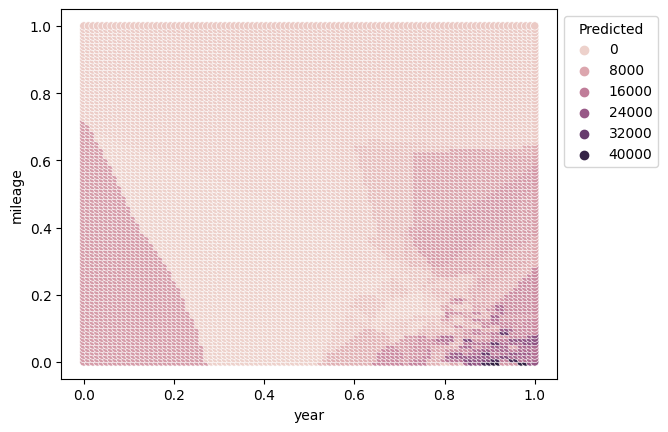

In [327]:
# 3 Nearest Neighbors
train_dat = plot_regression(X_train, y_train, k=3)

SSE_test = compute_SSE(3, X_train, y_train, X_test, y_test)
print(SSE_test)


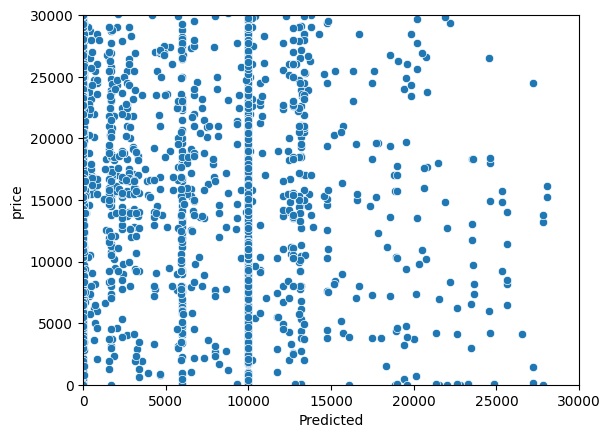

In [328]:
test_vs_train_scatter(train_dat)

'SSE with k=10:   55401092793.409996'

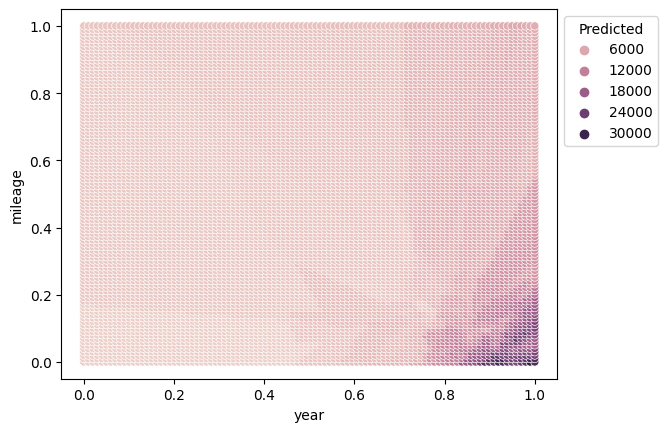

In [329]:
# 10 Nearest Neighbors
train_dat = plot_regression(X_test, y_test, k=10)
compute_SSE(10, X_train, y_train, X_test, y_test)

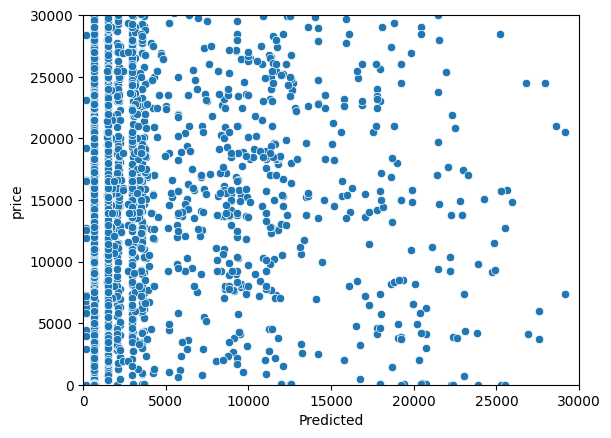

In [330]:
test_vs_train_scatter(train_dat)

'SSE with k=25:   51585228924.304'

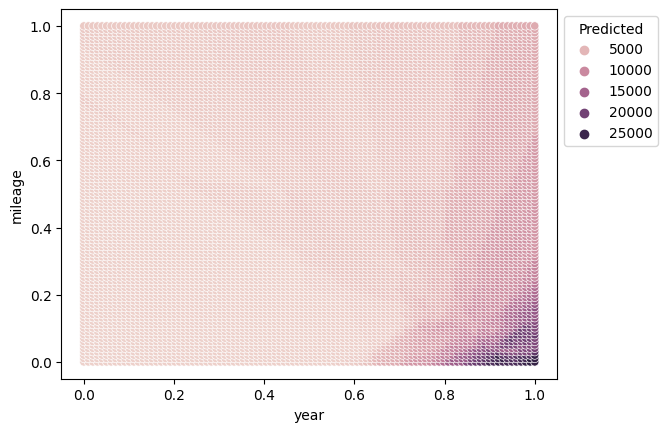

In [331]:
# 25 Nearest Neighbors
train_dat = plot_regression(X_test, y_test, k=25)
compute_SSE(25, X_train, y_train, X_test, y_test)

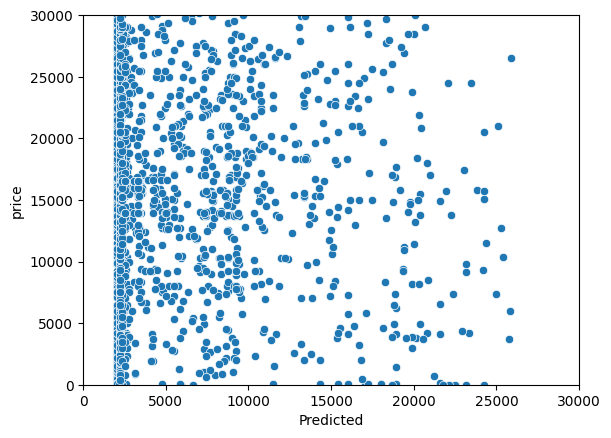

In [332]:
test_vs_train_scatter(train_dat)

'SSE with k=50:   49847721982.09799'

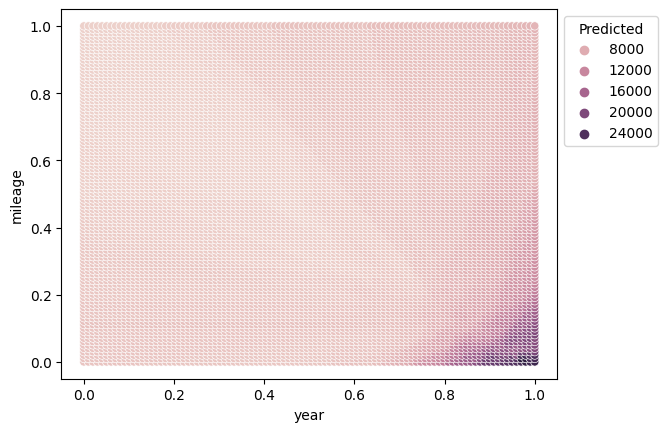

In [333]:
# 50 Nearest Neighbors
train_dat = plot_regression(X_test, y_test, k=50)
compute_SSE(50, X_train, y_train, X_test, y_test)

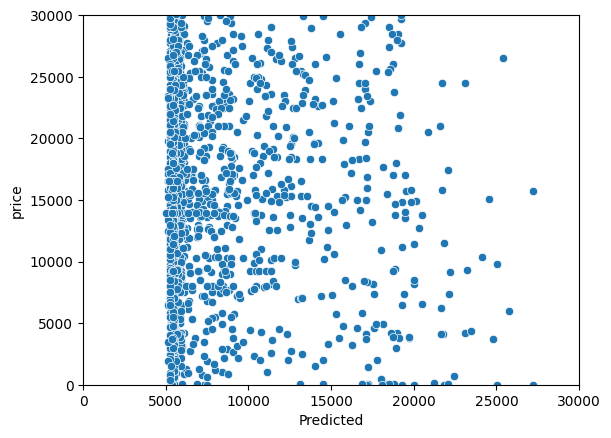

In [334]:
test_vs_train_scatter(train_dat)

'SSE with k=100:   49135529480.4603'

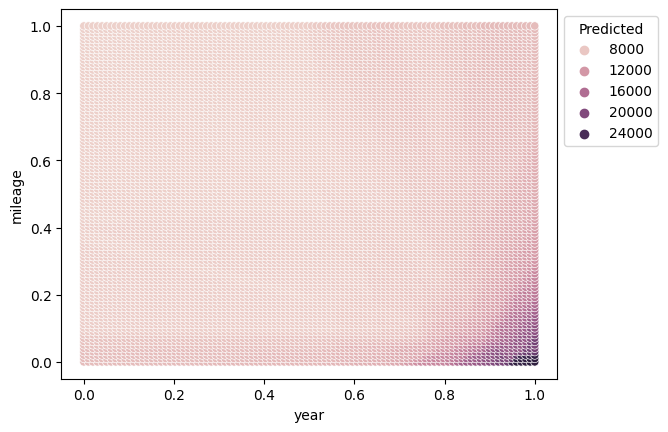

In [335]:
# 100 Nearest Neighbors
train_dat = plot_regression(X_test, y_test, k=100)
compute_SSE(100, X_train, y_train, X_test, y_test)

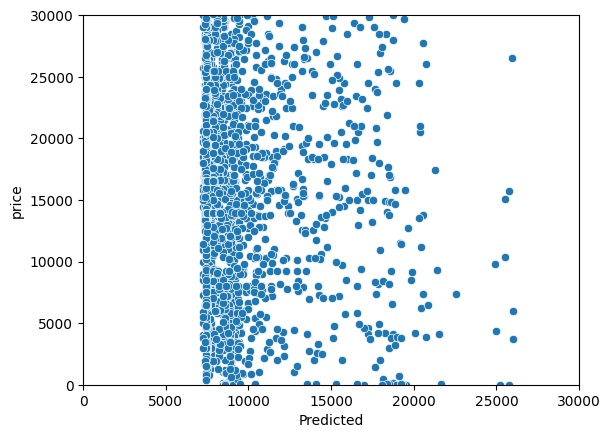

In [336]:
test_vs_train_scatter(train_dat)

'SSE with k=300:   50238649457.106'

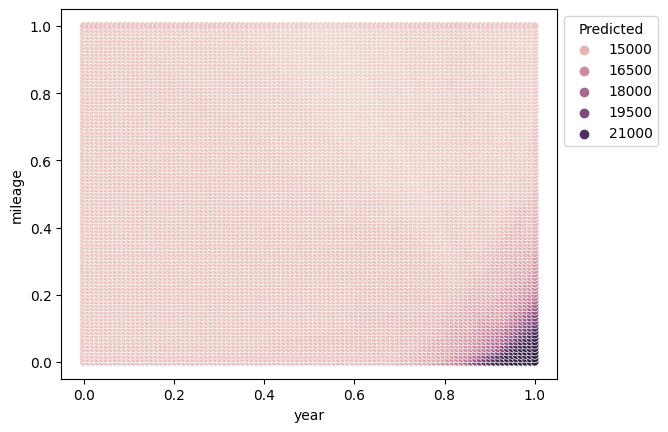

In [337]:
# 300 Nearest Neighbors
train_dat = plot_regression(X_test, y_test, k=300)
compute_SSE(300, X_train, y_train, X_test, y_test)

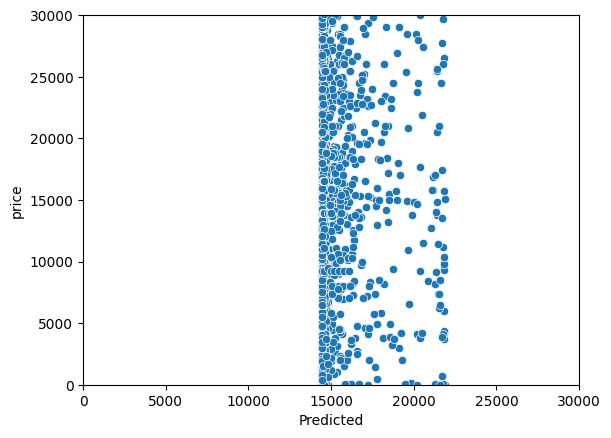

In [338]:
test_vs_train_scatter(train_dat)

<font color="green"> As k is increased, the predictions made by the model get closer and closer to the mean, before reaching a point where nearly all predictions are in a close range around the mean. This greatly minimizes the usefulness of the model, as predicting based on a mean removes all natural variability present in the data. </font>

k where SSE is minimized: [77]


Text(0, 0.5, 'SSE')

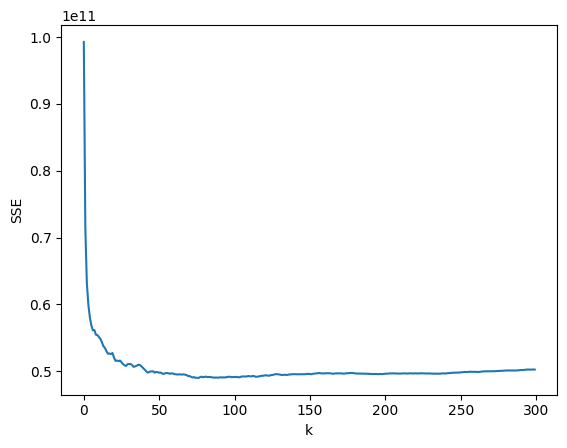

In [339]:
# Determine optimal k val for this data
k_bar = 300
k_grid = np.arange(1,k_bar)
SSE_train = np.zeros(k_bar)
SSE_test = np.zeros(k_bar)
for k in range(k_bar):
    model = kNNRegression(n_neighbors=k+1) # Create a sk model for k
    fitted_model = model.fit(X_train,y_train) # Train the model on our data
    y_hat = fitted_model.predict(X_test) # Predict values for test set
    SSE_test[k] = np.sum( (y_test-y_hat)**2 ) # Save the computed SSE
    y_hat = fitted_model.predict(X_train) # Predict values for training set
    SSE_train[k] = np.sum( (y_train-y_hat)**2 ) # Save the computed SSE

SSE_min = np.min(SSE_test) # Lowest recorded SSE
min_index = np.where(SSE_test == SSE_min) # Find the indices of y that equal the minimum
k_star = k_grid[min_index] # Find the optimal value of k

print("k where SSE is minimized:", k_star)

plt.plot(np.arange(0,k_bar),SSE_test,label='Test') # Plot SSE by k
plt.xlabel("k")
plt.ylabel("SSE")


<font color="green"> SSE is minimized at k=77, so this would be the most ideal value to use for our k nearest neighbors algorithm.
</font>

**Q3.** This question is a case study for $k$ nearest neighbor, particularly variable selection. The data for the question include (summaries reproduced here directly from the codebook):

- age: age of the patient (years)
- anaemia: decrease of red blood cells or hemoglobin (boolean)
- high blood pressure: if the patient has hypertension (boolean)
- creatinine phosphokinase (CPK): level of the CPK enzyme in the blood (mcg/L)
- diabetes: if the patient has diabetes (boolean)
- ejection fraction: percentage of blood leaving the heart at each contraction (percentage)
- platelets: platelets in the blood (kiloplatelets/mL)
- sex: woman or man (binary)
- serum creatinine: level of serum creatinine in the blood (mg/dL)
- serum sodium: level of serum sodium in the blood (mEq/L)
- smoking: if the patient smokes or not (boolean)
- time: follow-up period (days)
- death event: if the patient deceased during the follow-up period (boolean)

1. Load the `./data/heart_failure_clinical_records_dataset.csv`. Are there any `NA`'s to handle? use `.drop()` to remove `time` from the dataframe.
2. Make a correlation matrix. What variables are strongly associated with a death event?
3. For the dummy variables `anaemia`, `diabetes`, `high_blood_pressure`, `sex`, and `smoking`, compute a summary table of `DEATH_EVENT` grouped by the variable. For which variables does a higher proportion of the population die when the variable takes the value 1 rather than 0?
4. On the basis of your answers from 2 and 3, build a matrix $X$ of the variables you think are most predictive of a death, and a variable $y$ equal to `DEATH_EVENT`.
5. Maxmin normalize all of the variables in `X`.
6. Split the sample into ~80% for training and ~20% for evaluation. (Try to use the same train/test split for the whole question, so that you're comparing apples to apples in the questions below.).
7. Determine the optimal number of neighbors for a $k$NN regression for the variables you selected.
8. OK, do steps 5 through 7 again, but use all of the variables (except `time`). Which model has a lower Sum of Squared Error? Which would you prefer to use in practice, if you had to predict `DEATH_EVENT`s? If you play with the selection of variables, how much does the SSE change for your fitted model on the test data? Are more variables better, in this case? Explain your findings.

**Q4.** Let's do some very basic computer vision. We're going to import the MNIST handwritten digits data and $k$NN to predict values (i.e. "see/read").

1. To load the data, run the following code in a chunk:
```
from keras.datasets import mnist
df = mnist.load_data('minst.db')
train,test = df
X_train, y_train = train
X_test, y_test = test
```
The `y_test` and `y_train` vectors, for each index `i`, tell you want number is written in the corresponding index in `X_train[i]` and `X_test[i]`. The value of `X_train[i]` and `X_test[i]`, however, is a 28$\times$28 array whose entries contain values between 0 and 256. Each element of the matrix is essentially a "pixel" and the matrix encodes a representation of a number. To visualize this, run the following code to see the first ten numbers:
```
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000)
for i in range(5):
    print(y_test[i],'\n') # Print the label
    print(X_test[i],'\n') # Print the matrix of values
    plt.contourf(np.rot90(X_test[i].transpose())) # Make a contour plot of the matrix values
    plt.show()
```
OK, those are the data: Labels attached to handwritten digits encoded as a matrix.

2. What is the shape of `X_train` and `X_test`? What is the shape of `X_train[i]` and `X_test[i]` for each index `i`? What is the shape of `y_train` and `y_test`?
3. Use Numpy's `.reshape()` method to covert the training and testing data from a matrix into an vector of features. So, `X_test[index].reshape((1,784))` will convert the $index$-th element of `X_test` into a $28\times 28=784$-length row vector of values, rather than a matrix. Turn `X_train` into an $N \times 784$ matrix $X$ that is suitable for scikit-learn's kNN classifier where $N$ is the number of observations and $784=28*28$ (you could use, for example, a `for` loop).
4. Use the reshaped `X_test` and `y_test` data to create a $k$-nearest neighbor classifier of digit. What is the optimal number of neighbors $k$? If you can't determine this, play around with different values of $k$ for your classifier.
5. For the optimal number of neighbors, how well does your predictor perform on the test set?
6. So, this is how computers "see." They convert an image into a matrix of values, that matrix becomes a vector in a dataset, and then we deploy ML tools on it as if it was any other kind of tabular data. To make sure you follow this, invent a way to represent a color photo in matrix form, and then describe how you could convert it into tabular data. (Hint: RGB color codes provide a method of encoding a numeric value that represents a color.)

**Q5.** This question is a case study for $k$ means clustering.

1. Load the `airbnb_hw.csv` data. Clean `Price` along with `Beds`, `Number of Reviews`, and `Review Scores Rating`.
2. Maxmin normalize the data and remove any `nan`'s (`KMeans` from `sklearn` doesn't accept `nan` input).
3. Use `sklearn`'s `KMeans` module to cluster the data by `Beds`, `Number of Reviews`, and `Review Scores Rating` for `k=6`.
4. Use `seaborn`'s `.pairplot()` to make a grid of scatterplots that show how the clustering is carried out in multiple dimensions.
5. Use `.groupby` and `.describe` to compute the average price for each cluster. Which clusters have the highest rental prices?
6. Use a scree plot to pick the number of clusters and repeat steps 4 and 5.

In [340]:
# Load and clean data
abnb_dat = pd.read_csv("./assignment3/data/airbnb_hw.csv")
abnb_dat = abnb_dat[['Price', 'Beds', 'Number Of Reviews', 'Review Scores Rating']] # only keep essential columns

#print(abnb_dat['Price'].value_counts())
abnb_dat['Price'] = abnb_dat['Price'].str.replace(',', '')
abnb_dat['Price'] = abnb_dat['Price'].astype(int)
print(abnb_dat['Price'].isna().sum()) # price is clean
print(abnb_dat['Price'].dtypes)

print(abnb_dat['Number Of Reviews'].isna().sum()) # number of reviews is clean
print(abnb_dat['Number Of Reviews'].dtypes)

print(abnb_dat['Beds'].isna().sum()) # clean, NaNs present
print(abnb_dat['Beds'].dtypes)
#print(abnb_dat['Beds'].value_counts())

print(abnb_dat['Review Scores Rating'].isna().sum())
print(abnb_dat['Review Scores Rating'].dtypes)



0
int64
0
int64
85
float64
8323
float64


In [341]:
# Remove all nan's and maxmin normalize the data
X = abnb_dat.dropna() # remove all rows with any nan values
X = X.apply(maxmin)
X.describe()

Price          Beds  Number Of Reviews  Review Scores Rating
count  22111.000000  22111.000000       22111.000000          22111.000000
mean       0.014494      0.097381           0.060637              0.899895
std        0.014905      0.065251           0.095009              0.110650
min        0.000000      0.000000           0.000000              0.000000
25%        0.007508      0.062500           0.007812              0.862500
50%        0.011512      0.062500           0.023438              0.925000
75%        0.018018      0.125000           0.074219              1.000000
max        1.000000      1.000000           1.000000              1.000000

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: xlabel='Number Of Reviews', ylabel='Review Scores Rating'>

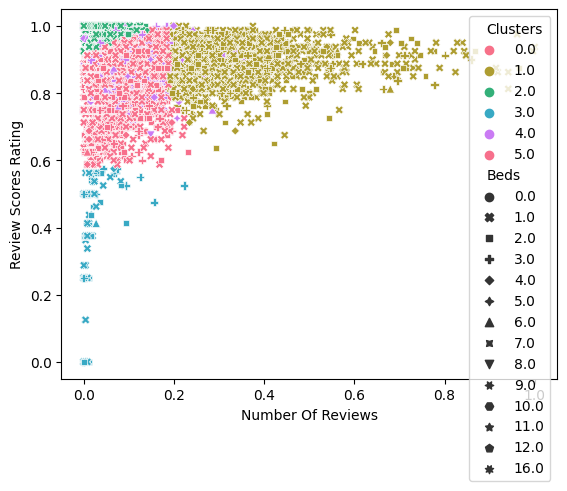

In [342]:
# Use sklearn's KMeans module to cluster the data by Beds, Number of Reviews, and Review Scores Rating for k=6.
from sklearn.cluster import KMeans

X = X[['Review Scores Rating', 'Number Of Reviews', 'Beds', 'Price']]

kmeans = KMeans(n_clusters=6)
X['Clusters'] = kmeans.fit_predict(X)

sns.scatterplot(X, x='Number Of Reviews', y='Review Scores Rating', hue='Clusters', palette='husl', style=abnb_dat['Beds'])
# not sure what the top legend is about... for some reason duplicated

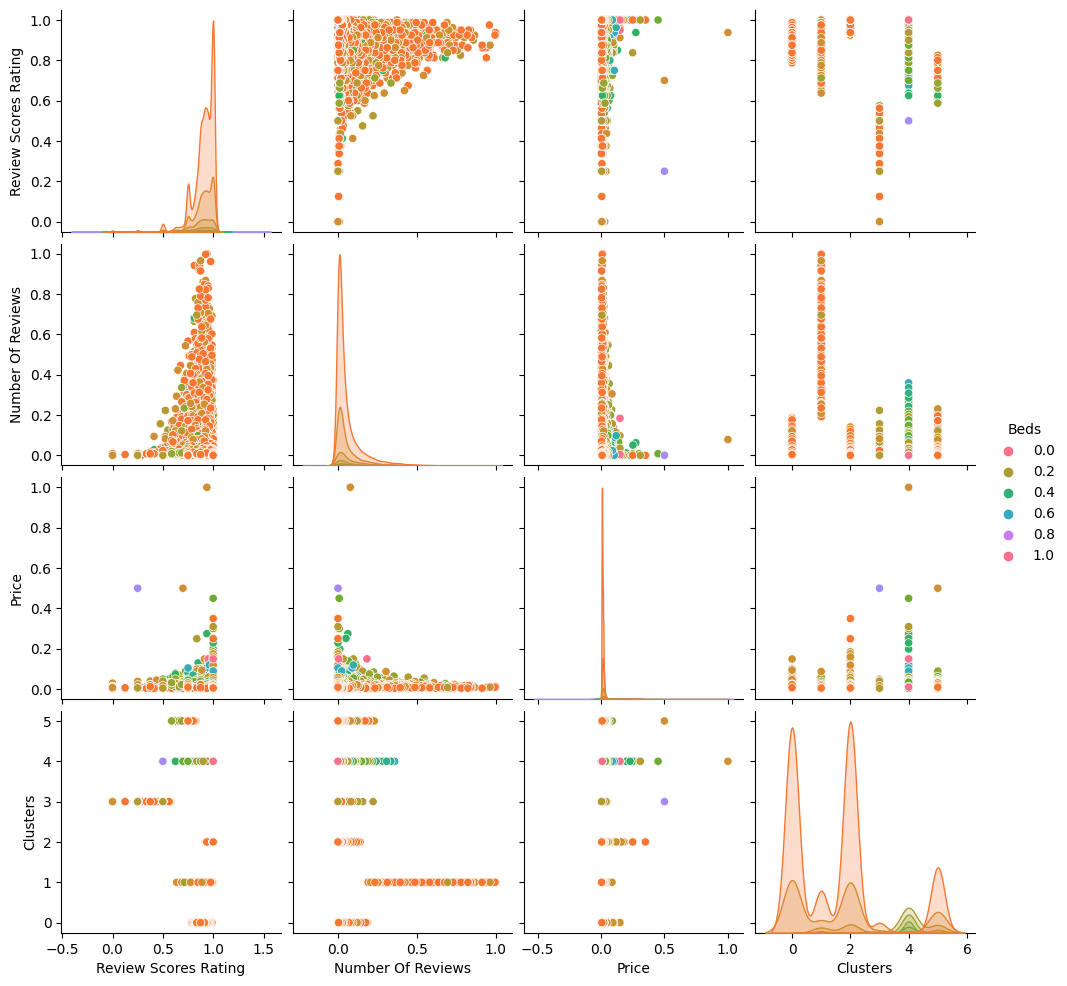

In [343]:
# Use seaborn's .pairplot() to make a grid of scatterplots that show how the clustering is carried out in multiple dimensions.
sns.pairplot(X, hue='Beds', palette='husl')

In [344]:
# Use .groupby and .describe to compute the average price for each cluster. Which clusters have the highest rental prices?

X.groupby('Clusters').describe()

Review Scores Rating                                              \
                        count      mean       std     min     25%     50%   
Clusters                                                                    
0                      7459.0  0.894366  0.036554  0.7875  0.8750  0.9000   
1                      1797.0  0.898143  0.054532  0.6375  0.8625  0.9000   
2                      7817.0  0.987706  0.020213  0.9250  0.9750  1.0000   
3                       409.0  0.415923  0.162388  0.0000  0.3750  0.5000   
4                      1758.0  0.901870  0.066999  0.5000  0.8625  0.9125   
5                      2871.0  0.744009  0.051027  0.5875  0.7500  0.7500   

                         Number Of Reviews            ...    Beds          \
             75%     max             count      mean  ...     75%     max   
Clusters                                              ...                   
0         0.9250  0.9875            7459.0  0.060392  ...  0.1250  0.1250   
1         0.9375  1.0000            1797.0  0.316676  ...  0.1250  0.4375   
2         1.0000  1.0000            7817.0  0.016861  ...  0.1250  0.1875   
3         0.5000  0.5750             409.0  0.007173  ...  0.1250  0.7500   
4         0.9500  1.0000            1758.0  0.060545  ...  0.3125  1.0000   
5         0.7750  0.8250            2871.0  0.027884  ...  0.1250  0.3750   

           Price                                                              \
           count      mean       std       min       25%       50%       75%   
Clusters                                                                       
0         7459.0  0.012668  0.007952  0.001201  0.007207  0.011011  0.016517   
1         1797.0  0.012550  0.007840  0.001702  0.007508  0.011011  0.016016   
2         7817.0  0.014408  0.011403  0.000000  0.007508  0.012012  0.018519   
3          409.0  0.012007  0.025560  0.001502  0.005005  0.008008  0.014014   
4         1758.0  0.028986  0.035331  0.001702  0.014014  0.021722  0.034034   
5         2871.0  0.012173  0.012310  0.001001  0.006006  0.009910  0.015516   

                    
               max  
Clusters            
0         0.148649  
1         0.086587  
2         0.349349  
3         0.499499  
4         1.000000  
5         0.499499  

[6 rows x 32 columns]

<font color="green">
Cluster 4 has the highest mean Price, which is more than double any of the other clusters. Cluster 3 has marginally higher Prices typically, as well. The other four clusters have similar mean Prices, as well as interquartile ranges.
</font>

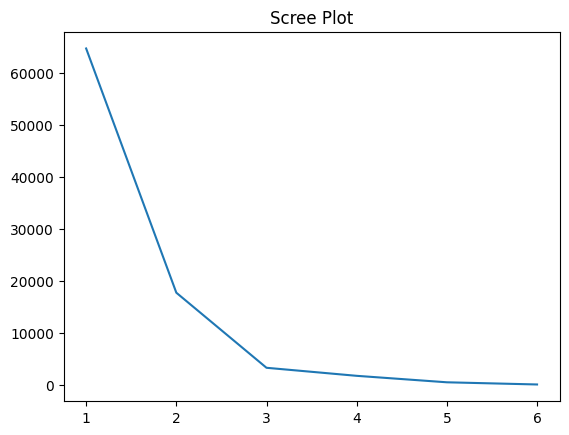

In [345]:
# Use a scree plot to pick the number of clusters and repeat steps 4 and 5.
k_bar = 6
k_grid = np.arange(1,k_bar+1) # The range of k's to consider
SSE = np.zeros(k_bar) # We'll store the training error here
for k in range(k_bar): # For indices from 0 to k_bar-1
    model = KMeans(n_clusters=k+1, max_iter=300, n_init = 10, random_state=0) # Create a model for k
    model = model.fit(X) # Fit the emodel
    SSE[k] = model.inertia_ # Record the sum of squared error for k in the SSE vector

scree_plot = sns.lineplot(x=k_grid, y=SSE).set_title('Scree Plot') # Create scree plot

<font color="green">
The optimal k value is found where the SSE drops significantly from k-1 to k compared to fro k to k+1. On this scree plot, that point is at 2, for any additional k's yields descreasing marginal benefits in minimizing SSE.
</font>

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


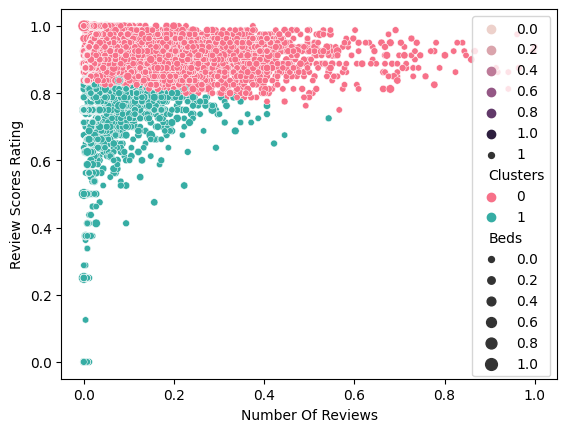

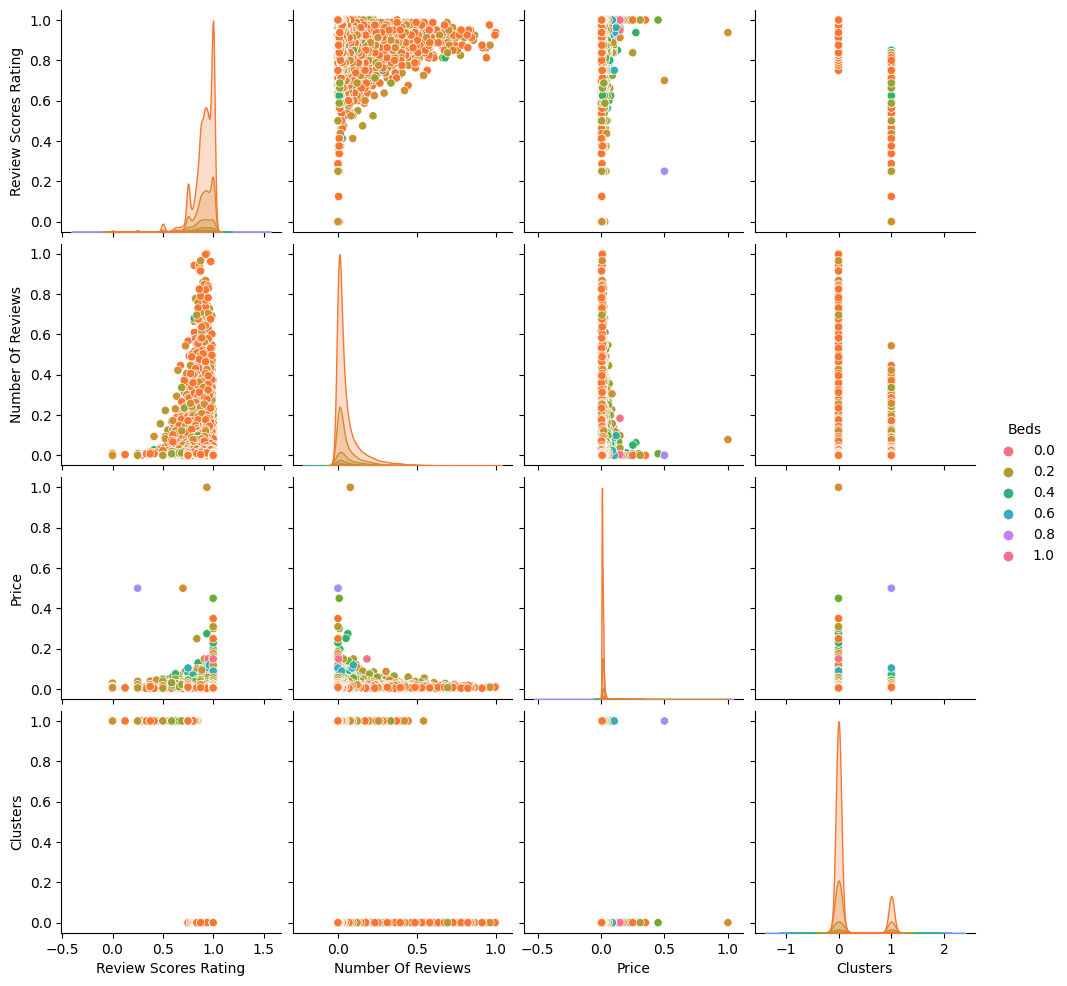

In [346]:
# Try k=2
from sklearn.cluster import KMeans

sns.scatterplot(X, x='Number Of Reviews', y='Review Scores Rating', hue='Beds', size=1)

X = X[['Review Scores Rating', 'Number Of Reviews', 'Beds', 'Price']]

kmeans = KMeans(n_clusters=2)
X['Clusters'] = kmeans.fit_predict(X)

sns.scatterplot(X, x='Number Of Reviews', y='Review Scores Rating', hue='Clusters', palette='husl', size='Beds')

sns.pairplot(X, hue='Beds', palette='husl')


In [347]:

X.groupby('Clusters').describe()

Review Scores Rating                                            \
                        count      mean       std   min     25%     50%   
Clusters                                                                  
0                     18424.0  0.937353  0.054866  0.75  0.8875  0.9375   
1                      3687.0  0.712720  0.127818  0.00  0.7125  0.7500   

                       Number Of Reviews            ...   Beds         Price  \
             75%   max             count      mean  ...    75%  max    count   
Clusters                                            ...                        
0         1.0000  1.00           18424.0  0.066077  ...  0.125  1.0  18424.0   
1         0.7875  0.85            3687.0  0.033455  ...  0.125  1.0   3687.0   

                                                                                
              mean       std       min       25%       50%       75%       max  
Clusters                                                                        
0         0.014784  0.014874  0.000000  0.007608  0.012012  0.018218  1.000000  
1         0.013048  0.014978  0.001001  0.006006  0.010010  0.016517  0.499499  

[2 rows x 32 columns]

**Q6.** This is a question about $k$ means clustering. We want to investigate how adjusting the "noisiness" of the data impacts the quality of the algorithm and the difficulty of picking $k$.

1. Run the code below, which creates four datasets: `df0_125`, `df0_25`, `df0_5`, `df1_0`, and `df2_0`. Each data set is created by increasing the amount of `noise` (standard deviation) around the cluster centers, from `0.125` to `0.25` to `0.5` to `1.0` to `2.0`.

```
import numpy as np
import pandas as pd

def createData(noise,N=50):
    np.random.seed(100) # Set the seed for replicability
    # Generate (x1,x2,g) triples:
    X1 = np.array([np.random.normal(1,noise,N),np.random.normal(1,noise,N)])
    X2 = np.array([np.random.normal(3,noise,N),np.random.normal(2,noise,N)])
    X3 = np.array([np.random.normal(5,noise,N),np.random.normal(3,noise,N)])
    # Concatenate into one data frame
    gdf1 = pd.DataFrame({'x1':X1[0,:],'x2':X1[1,:],'group':'a'})
    gdf2 = pd.DataFrame({'x1':X2[0,:],'x2':X2[1,:],'group':'b'})
    gdf3 = pd.DataFrame({'x1':X3[0,:],'x2':X3[1,:],'group':'c'})
    df = pd.concat([gdf1,gdf2,gdf3],axis=0)
    return df

df0_125 = createData(0.125)
df0_25 = createData(0.25)
df0_5 = createData(0.5)
df1_0 = createData(1.0)
df2_0 = createData(2.0)
```

2. Make scatterplots of the $(X1,X2)$ points by group for each of the datasets. As the `noise` goes up from 0.125 to 2.0, what happens to the visual distinctness of the clusters?
3. Create a scree plot for each of the datasets. Describe how the level of `noise` affects the scree plot (particularly the presence of a clear "elbow") and your ability to definitively select a $k$.
4. Explain the intuition of the elbow, using this numerical simulation as an example.

**Q7.** We looked at computer vision with $k$NN in a previous question. Can $k$ means clustering correctly group digits, even if we don't know which symbols are which?

1. To load the data, run the following code in a chunk:
```
from keras.datasets import mnist
df = mnist.load_data('minst.db')
train,test = df
X_train, y_train = train
X_test, y_test = test
```
The `y_test` and `y_train` vectors, for each index `i`, tell you want number is written in the corresponding index in `X_train[i]` and `X_test[i]`. The value of `X_train[i]` and `X_test[i]`, however, is a 28$\times$28 array whose entries contain values between 0 and 256. Each element of the matrix is essentially a "pixel" and the matrix encodes a representation of a number. To visualize this, run the following code to see the first ten numbers:
```
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000)
for i in range(5):
    print(y_test[i],'\n') # Print the label
    print(X_test[i],'\n') # Print the matrix of values
    plt.contourf(np.rot90(X_test[i].transpose())) # Make a contour plot of the matrix values
    plt.show()
```
OK, those are the data: Labels attached to handwritten digits encoded as a matrix.

2. What is the shape of `X_train` and `X_test`? What is the shape of `X_train[i]` and `X_test[i]` for each index `i`? What is the shape of `y_train` and `y_test`?
3. Use Numpy's `.reshape()` method to covert the training and testing data from a matrix into an vector of features. So, `X_test[index].reshape((1,784))` will convert the $index$-th element of `X_test` into a $28\times 28=784$-length row vector of values, rather than a matrix. Turn `X_train` into an $N \times 784$ matrix $X$ that is suitable for scikit-learn's kNN classifier where $N$ is the number of observations and $784=28*28$ (you could use, for example, a `for` loop).
4. Use $k$ means clustering on the reshaped `X_test` data with `k=10`.  
5. Cross tabulate the cluster assignments with the true labels for the test set values. How good is the correspondence? What proportion of digits are clustered correctly? Which digits are the hardest to distinguish from one another? Can $k$MC recover the latent digits 0 to 9, without even knowing what those digits were?
6. If you use a scree plot to determine the number of clusters $k$, does it pick 10 (the true number of digits), or not? If it fails to pick $k=10$, which digits does it tend to combine into the same classification?